# 1. Data Preprocessing


In [1]:
import pandas as pd

# 1.Reload the file after environment reset
df = pd.read_csv( "MBTA-Bus-Arrival-Departure-Times_2025-03.csv")

In [ ]:
# 2. Preserve data where route_id == "01" 
df = df[df["route_id"] == "01"].copy()
df = df[df["service_date"] == "2025-03-03"].copy()
print(df.shape)

(1719, 13)


In [ ]:
# 3. Preserve data columns of interest
cols = ["service_date", "route_id", "direction_id", "half_trip_id", "stop_id", "point_type", "scheduled", "actual"]
df = df[cols].copy()
print(df.shape)

(1719, 8)


In [ ]:
# 4. Convert the scheduled and actual columns to datetime
df["scheduled_time"] = pd.to_datetime(df["scheduled"]).dt.time
df["actual_time"] = pd.to_datetime(df["actual"]).dt.time
df.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,point_type,scheduled,actual,scheduled_time,actual_time
108486,2025-03-03,01,Outbound,15163.0,64,Startpoint,1900-01-01T10:07:00Z,1900-01-01T10:07:30Z,10:07:00,10:07:30
108487,2025-03-03,01,Outbound,15163.0,2,Midpoint,1900-01-01T10:08:00Z,1900-01-01T10:08:20Z,10:08:00,10:08:20
108488,2025-03-03,01,Outbound,15163.0,10590,Midpoint,1900-01-01T10:13:00Z,1900-01-01T10:14:03Z,10:13:00,10:14:03
108489,2025-03-03,01,Outbound,15163.0,188,Midpoint,1900-01-01T10:17:00Z,1900-01-01T10:17:57Z,10:17:00,10:17:57
108490,2025-03-03,01,Outbound,15163.0,93,Midpoint,1900-01-01T10:20:00Z,1900-01-01T10:21:37Z,10:20:00,10:21:37


In [ ]:
# 5. Extract start and end points
df_start = df[df["point_type"] == "Startpoint"].copy()
df_end = df[df["point_type"] == "Endpoint"].copy()

# 6. Rename columns for clarity
df_start = df_start.rename(columns={
    "scheduled_time": "scheduled_departure",
    "actual_time": "actual_departure",
    "stop_id": "origin_stop"
})

df_end = df_end.rename(columns={
    "scheduled_time": "scheduled_arrival",
    "actual_time": "actual_arrival",
    "stop_id": "destination_stop"
})

# 7. Merge start and end points
trips = pd.merge(
    df_start[["half_trip_id", "service_date", "direction_id", "origin_stop", "scheduled_departure", "actual_departure"]],
    df_end[["half_trip_id", "destination_stop", "scheduled_arrival", "actual_arrival"]],
    on="half_trip_id",
    how="inner"
)

# 8. Drop rows with NaN values in 'actual_arrival' or 'scheduled_departure'
trips = trips.dropna(subset=['actual_arrival', 'scheduled_departure'])
trips = trips.sort_values(by=["service_date", "scheduled_departure"]).reset_index(drop=True)

# 9. Display the final DataFrame
print(trips.shape)
trips.head()

(183, 9)


,half_trip_id,service_date,direction_id,origin_stop,scheduled_departure,actual_departure,destination_stop,scheduled_arrival,actual_arrival
0,17846.0,2025-03-03,Outbound,64,00:05:00,00:05:42,110,00:47:00,00:41:58
1,17867.0,2025-03-03,Inbound,110,00:05:00,00:05:24,64,00:44:00,00:44:32
2,17855.0,2025-03-03,Outbound,64,00:20:00,00:19:47,110,01:01:00,00:54:08
3,17891.0,2025-03-03,Inbound,110,00:20:00,00:20:27,64,00:57:00,00:57:04
4,17799.0,2025-03-03,Inbound,110,00:35:00,00:35:04,64,01:12:00,01:07:14


# 2.设定时间区间

In [ ]:
import datetime as dt

def select_trips(trips, start_time, horizon_hours):
    """
    Select trips based on a start time and a time horizon.
    Args:
        trips (DataFrame): DataFrame containing trip information.
        start_time (datetime.time): The start time for filtering trips.
        horizon_hours (int): The number of hours to look ahead from the start time.
    Returns:
        DataFrame: Filtered DataFrame containing trips within the specified time range.
    """
    # Compute the end time based on the start time and horizon
    start_dt = dt.datetime.combine(dt.date(2025, 3, 3), start_time)
    end_dt = start_dt + dt.timedelta(hours=horizon_hours)
    start_clock = start_dt.time()
    end_clock = end_dt.time()

    # Filter trips based on the scheduled departure time
    mask = (
        (trips['scheduled_departure'] >= start_clock) &
        (trips['scheduled_departure'] < end_clock)
    )
    
    return trips.loc[mask].sort_values('scheduled_departure').reset_index(drop=True)


In [ ]:
# Set parameters
start_time   = dt.time(8, 0, 0)           # 8:00 AM
horizon      = 2                          # 2 hours

trips_sample_2 = select_trips(trips, start_time, horizon)
print(trips_sample_2.shape)

(2, 9)


In [ ]:
# Set parameters
start_time   = dt.time(8, 0, 0)           # 8:00 AM
horizon      = 4                          # 4 hours

trips_sample_4 = select_trips(trips, start_time, horizon)
print(trips_sample_4.shape)

(23, 9)


In [ ]:
# Set parameters
service_date = dt.date(2025, 3, 3)       
start_time   = dt.time(8, 0, 0)           # 8:00 AM
horizon      = 6                          # 6 hours

trips_sample_6 = select_trips(trips, start_time, horizon)
print(trips_sample_6.shape)

(43, 9)


In [ ]:
# Set parameters
start_time   = dt.time(8, 0, 0)           # 8:00 AM
horizon      = 8                          # 8 hours

trips_sample_8 = select_trips(trips, start_time, horizon)
print(trips_sample_8.shape)

(60, 9)


In [ ]:
service_date = dt.date(2025, 3, 3)       
start_time   = dt.time(8, 0, 0)          
horizon      = 10                      

trips_sample_10 = select_trips(trips, start_time, horizon)
print(trips_sample_10.shape)

(77, 9)


In [ ]:
service_date = dt.date(2025, 3, 3)       
start_time   = dt.time(8, 0, 0)           
horizon      = 12                          

trips_sample_12 = select_trips(trips, start_time, horizon)
print(trips_sample_12.shape)

(94, 9)


In [ ]:
service_date = dt.date(2025, 3, 3)      
start_time   = dt.time(8, 0, 0)           
horizon      = 14                         

trips_sample_14 = select_trips(trips, start_time, horizon)
print(trips_sample_14.shape)

(115, 9)


# 3. Model Construction

In [ ]:
# max_layover: maximum layover time
# min_turn_time 或 min_turn: minimum turn time
# max_chain_length: maximum number of trips in a chain used for Set Partitioning to control the length of generated chains and prevent explosive combinations 

## 3.1. Arc Flow

In [ ]:
def build_arc_flow_clean(trips, min_turn=2, max_layover=60):
    from datetime import datetime
    arcs = []
    today = datetime.today().date()
    n = len(trips)

    for i in range(n):
        for j in range(n):
            if trips.loc[i, 'destination_stop'] == trips.loc[j, 'origin_stop']:
                arr_raw = trips.loc[i, 'actual_arrival']
                dep_raw = trips.loc[j, 'scheduled_departure']

                if pd.isna(arr_raw) or pd.isna(dep_raw):
                    continue

                dep = datetime.combine(today, dep_raw)
                arr = datetime.combine(today, arr_raw)
                wait = (dep - arr).total_seconds() / 60

                if min_turn <= wait <= max_layover:
                    arcs.append((i, j))
    return arcs

def solve_arc_flow_fast(trips, arcs):
    import time
    model = gp.Model("arc_flow_fast")
    n = len(trips)
    x = {}

    for (u, v) in arcs:
        x[u, v] = model.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

    for i in range(n):
        model.addConstr(gp.quicksum(x[u, v] for (u, v) in arcs if u == i) <= 1)
        model.addConstr(gp.quicksum(x[u, v] for (u, v) in arcs if v == i) <= 1)

    model.setObjective(gp.quicksum(x[u, v] for (u, v) in arcs), GRB.MAXIMIZE)
    model.setParam('OutputFlag', 0)
    model.setParam('TimeLimit', 60)

    start = time.time()
    model.optimize()
    solve_time = time.time() - start

    max_matching = model.objVal
    min_buses = n - int(max_matching)

    # SAFE extraction
    x_values = {}
    for (u, v) in arcs:
        if (u, v) in x and x[u, v].X > 0.5:
            x_values[(u, v)] = 1

    return min_buses, solve_time, x_values

# Extract paths from the solution
def extract_paths_from_solution(arcs, x_values, n):
    selected_arcs = [(u, v) for (u, v) in arcs if x_values.get((u, v), 0) > 0.5]
    from_to = {u: v for (u, v) in selected_arcs if u != n}
    starts = [u for (u, v) in selected_arcs if u == -1 or all(u != j for (_, j) in selected_arcs)]

    paths = []
    for start in starts:
        path = [start]
        while path[-1] in from_to:
            path.append(from_to[path[-1]])
        paths.append(path)

    return paths

# Print bus schedules
def print_bus_schedules(paths, trips):
    for bus_id, path in enumerate(paths, 1):
        print(f"\n=== Bus {bus_id} Schedule ===")
        for trip_idx in path:
            trip = trips.loc[trip_idx]
            dep = trip['actual_departure']
            arr = trip['actual_arrival']
            origin = trip['origin_stop']
            dest = trip['destination_stop']
            print(f"Trip {int(trip['half_trip_id'])}: {dep} → {arr} ({origin} → {dest})")

## 3.2. Set Partitioning

In [ ]:
# Generate chains of trips based on the layover time and maximum chain length
def find_feasible_chains(trips, max_layover=60, max_chain_length=4): 
    today = datetime.today().date()
    n = len(trips)
    chains = []

    def dfs(path):
        if len(path) >= max_chain_length:
            chains.append(path[:])
            return

        last_trip = path[-1]
        last_arr = datetime.combine(today, trips.loc[last_trip, 'actual_arrival'])

        for next_trip in range(n):
            if next_trip in path:
                continue
            if trips.loc[last_trip, 'destination_stop'] == trips.loc[next_trip, 'origin_stop']:
                next_dep = datetime.combine(today, trips.loc[next_trip, 'scheduled_departure'])
                layover = (next_dep - last_arr).total_seconds() / 60
                if 2 <= layover <= max_layover:
                    path.append(next_trip)
                    dfs(path)
                    path.pop()

        if len(path) > 1:
            chains.append(path[:])

    for i in range(n):
        dfs([i])

    return chains

# Solve the Set Partitioning Model
def solve_set_partitioning(trips, chains):
    import time
    model = gp.Model("set_partitioning")
    model.setParam("OutputFlag", 0)
    model.setParam('TimeLimit', 60)

    n = len(trips)
    m = len(chains)

    y = []
    for k in range(m):
        y.append(model.addVar(vtype=GRB.BINARY, name=f"y_{k}"))

    for i in range(n):
        model.addConstr(gp.quicksum(y[k] for k in range(m) if i in chains[k]) == 1)

    model.setObjective(gp.quicksum(y), GRB.MINIMIZE)

    start = time.time()
    model.optimize()
    solve_time = time.time() - start

    used_chains = [chains[k] for k in range(m) if y[k].X > 0.5]
    min_buses = len(used_chains)

    return min_buses, solve_time, used_chains

# Print the partitioning schedule
def print_partitioning_schedule(chains, trips):
    for bus_id, path in enumerate(chains, 1):
        print(f"\n=== Bus {bus_id} Schedule ===")
        for trip_idx in path:
            trip = trips.loc[trip_idx]
            dep = trip['actual_departure']
            arr = trip['actual_arrival']
            origin = trip['origin_stop']
            dest = trip['destination_stop']
            print(f"Trip {int(trip['half_trip_id'])}: {dep} → {arr} ({origin} → {dest})")

# 4. Model Comparison

### 4 hours

In [17]:
import gurobipy as gp  # Import Gurobi's Python API
from gurobipy import GRB  # Import GRB constants
from datetime import datetime  # Import datetime module

arcs = build_arc_flow_clean(trips_sample_4)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_4, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_4))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 4))
print_bus_schedules(paths, trips_sample_4)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_4, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_4, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 4)}")
print_partitioning_schedule(used_chains, trips_sample_4)

Set parameter Username
Set parameter LicenseID to value 2599466
Academic license - for non-commercial use only - expires 2025-12-14
Set parameter LicenseID to value 2599466
Academic license - for non-commercial use only - expires 2025-12-14
***Arc Flow Result***
Total buses assigned: 7
Solving time (seconds): 0.001

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 15181: 10:58:20 → 11:25:45 (64 → 110)
Trip 15182: 11:30:22 → 12:05:24 (110 → 64)

=== Bus 3 Schedule ===
Trip 15163: 10:07:30 → 10:33:13 (64 → 110)
Trip 15164: 10:36:01 → 11:03:45 (110 → 64)
Trip 15197: 11:17:10 → 11:44:28 (64 → 110)
Trip 15198: 11:51:16 → 12:21:58 (110 → 64)

=== Bus 4 Schedule ===
Trip 15204: 10:22:10 → 10:46

### 6 hours

In [18]:
arcs = build_arc_flow_clean(trips_sample_6)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_6, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_6))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 6))
print_bus_schedules(paths, trips_sample_6)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_6, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_6, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 6)}")
print_partitioning_schedule(used_chains, trips_sample_6)

***Arc Flow Result***
Total buses assigned: 9
Solving time (seconds): 0.003998

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)
Trip 15184: 12:49:30 → 13:36:49 (110 → 64)
Trip 15169: 13:50:40 → 14:29:33 (64 → 110)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 15181: 10:58:20 → 11:25:45 (64 → 110)
Trip 15166: 11:39:31 → 12:09:58 (110 → 64)
Trip 15199: 12:31:36 → 13:04:57 (64 → 110)
Trip 15209: 13:24:10 → 14:05:08 (110 → 64)

=== Bus 3 Schedule ===
Trip 15163: 10:07:30 → 10:33:13 (64 → 110)
Trip 15164: 10:36:01 → 11:03:45 (110 → 64)
Trip 15197: 11:17:10 → 11:44:28 (64 → 110)
Trip 15207: 11:59:11 → 12:28:05 (110 → 64)
Trip 15224: 12:51:46 → 13:29:08 (64 → 110)
Trip 17787: 13:52:44 → 14:28:29 (110 → 64)

=== Bus 4 Schedule ===
Trip 152

### 8 hours

In [19]:
arcs = build_arc_flow_clean(trips_sample_8)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_8, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_8))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 8))
print_bus_schedules(paths, trips_sample_8)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_8, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_8, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 8)}")
print_partitioning_schedule(used_chains, trips_sample_8)

***Arc Flow Result***
Total buses assigned: 9
Solving time (seconds): 0.00168681

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)
Trip 15184: 12:49:30 → 13:36:49 (110 → 64)
Trip 15169: 13:50:40 → 14:29:33 (64 → 110)
Trip 15170: 14:39:36 → 15:20:19 (110 → 64)
Trip 15171: 15:31:28 → 16:08:00 (64 → 110)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 15181: 10:58:20 → 11:25:45 (64 → 110)
Trip 15166: 11:39:31 → 12:09:58 (110 → 64)
Trip 15199: 12:31:36 → 13:04:57 (64 → 110)
Trip 15209: 13:24:10 → 14:05:08 (110 → 64)
Trip 15226: 14:23:47 → 15:02:18 (64 → 110)
Trip 17789: 15:22:36 → 16:01:03 (110 → 64)

=== Bus 3 Schedule ===
Trip 15163: 10:07:30 → 10:33:13 (64 → 110)
Trip 15164: 10:36:01 → 11:03:45 (110 → 64)
Trip 15165: 11:09:25 → 11:35:5

### 10 hours

In [20]:
arcs = build_arc_flow_clean(trips_sample_10)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_10, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_10))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 10))
print_bus_schedules(paths, trips_sample_10)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_10, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_10, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 10)}")
print_partitioning_schedule(used_chains, trips_sample_10)

***Arc Flow Result***
Total buses assigned: 9
Solving time (seconds): 0.0

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)
Trip 15184: 12:49:30 → 13:36:49 (110 → 64)
Trip 15169: 13:50:40 → 14:29:33 (64 → 110)
Trip 15170: 14:39:36 → 15:20:19 (110 → 64)
Trip 15212: 15:46:41 → 16:19:59 (64 → 110)
Trip 15229: 16:45:52 → 17:37:40 (110 → 64)
Trip 17792: 17:53:25 → 18:31:16 (64 → 110)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 18848: 10:49:17 → 11:11:55 (64 → 110)
Trip 15182: 11:30:22 → 12:05:24 (110 → 64)
Trip 15167: 12:29:24 → 13:05:09 (64 → 110)
Trip 15200: 13:14:52 → 13:49:33 (110 → 64)
Trip 15210: 14:10:19 → 14:41:47 (64 → 110)
Trip 15227: 15:07:38 → 15:48:46 (110 → 64)
Trip 17790: 16:11:54 → 16:44:27 (64 → 110)
Trip 17813: 17:13:

### 12 hours

In [21]:
arcs = build_arc_flow_clean(trips_sample_12)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_12, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_12))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 12))
print_bus_schedules(paths, trips_sample_12)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_12, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_12, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 12)}")
print_partitioning_schedule(used_chains, trips_sample_12)

***Arc Flow Result***
Total buses assigned: 9
Solving time (seconds): 0.00243473053

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)
Trip 15184: 12:49:30 → 13:36:49 (110 → 64)
Trip 15169: 13:50:40 → 14:29:33 (64 → 110)
Trip 15170: 14:39:36 → 15:20:19 (110 → 64)
Trip 15212: 15:46:41 → 16:19:59 (64 → 110)
Trip 15229: 16:45:52 → 17:37:40 (110 → 64)
Trip 17792: 17:53:25 → 18:31:16 (64 → 110)
Trip 17793: 18:38:42 → 19:17:53 (110 → 64)
Trip 17794: 19:44:41 → 20:25:28 (64 → 110)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 18848: 10:49:17 → 11:11:55 (64 → 110)
Trip 15182: 11:30:22 → 12:05:24 (110 → 64)
Trip 15167: 12:29:24 → 13:05:09 (64 → 110)
Trip 15200: 13:14:52 → 13:49:33 (110 → 64)
Trip 15210: 14:10:19 → 14:41:47 (64 → 110)
Trip 152

### 14 hours

In [22]:
arcs = build_arc_flow_clean(trips_sample_14)
min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_14, arcs)
paths = extract_paths_from_solution(arcs, x_values, len(trips_sample_14))
print("***Arc Flow Result***")
print(f"Total buses assigned: {len(paths)}")
print("Solving time (seconds):", round(solve_time, 14))
print_bus_schedules(paths, trips_sample_14)

print("----------------------------------------------------------------------------")

chains = find_feasible_chains(trips_sample_14, max_layover=60)
min_buses, solve_time, used_chains = solve_set_partitioning(trips_sample_14, chains)
print("***Set Partitioning Result***")
print(f"Optimal number of buses: {min_buses}")
print(f"Solving time (seconds): {round(solve_time, 14)}")
print_partitioning_schedule(used_chains, trips_sample_14)

***Arc Flow Result***
Total buses assigned: 11
Solving time (seconds): 0.00143122673035

=== Bus 1 Schedule ===
Trip 18820: 09:36:37 → 09:56:55 (64 → 110)
Trip 18821: 10:05:16 → 10:25:44 (110 → 64)
Trip 18822: 10:38:03 → 11:07:03 (64 → 110)
Trip 18849: 11:17:20 → 11:45:00 (110 → 64)
Trip 17806: 11:55:05 → 12:25:39 (64 → 110)
Trip 15184: 12:49:30 → 13:36:49 (110 → 64)
Trip 15169: 13:50:40 → 14:29:33 (64 → 110)
Trip 15170: 14:39:36 → 15:20:19 (110 → 64)
Trip 15212: 15:46:41 → 16:19:59 (64 → 110)
Trip 15229: 16:45:52 → 17:37:40 (110 → 64)
Trip 17792: 17:53:25 → 18:31:16 (64 → 110)
Trip 17815: 18:53:21 → 19:35:28 (110 → 64)
Trip 17816: 19:51:33 → 20:28:29 (64 → 110)
Trip 15194: 21:04:03 → 21:52:52 (110 → 64)

=== Bus 2 Schedule ===
Trip 18846: 09:52:27 → 10:10:56 (64 → 110)
Trip 18847: 10:21:02 → 10:46:57 (110 → 64)
Trip 18848: 10:49:17 → 11:11:55 (64 → 110)
Trip 15182: 11:30:22 → 12:05:24 (110 → 64)
Trip 15167: 12:29:24 → 13:05:09 (64 → 110)
Trip 15200: 13:14:52 → 13:49:33 (110 → 64)
Trip

# 5.Sensitivity Analysis

### Arc Flow

In [ ]:
param_grid_arc = [
    {"min_turn": 2, "max_layover": 60},
    {"min_turn": 5, "max_layover": 60},
    {"min_turn": 5, "max_layover": 90},
    {"min_turn": 5, "max_layover": 120},
    {"min_turn": 10, "max_layover": 90},
    {"min_turn": 10, "max_layover": 120},
]

def build_arc_flow(trips, min_turn=2, max_layover=60):
    from datetime import datetime
    arcs = []
    today = datetime.today().date()
    n = len(trips)

    for i in range(n):
        for j in range(n):
            if trips.loc[i, 'destination_stop'] == trips.loc[j, 'origin_stop']:
                arr_raw = trips.loc[i, 'actual_arrival']
                dep_raw = trips.loc[j, 'scheduled_departure']

                if pd.isna(arr_raw) or pd.isna(dep_raw):
                    continue

                dep = datetime.combine(today, dep_raw)
                arr = datetime.combine(today, arr_raw)
                wait = (dep - arr).total_seconds() / 60

                if min_turn <= wait <= max_layover:
                    arcs.append((i, j))
    return arcs

### Set Partitioning

In [ ]:
import itertools

param_grid_set = [
    {"min_turn": min_turn, "max_layover": max_layover, "max_chain": max_chain}
    for min_turn, max_layover, max_chain in itertools.product([2, 5, 10], [60, 90,120], [3, 5])
]

def run_set_partitioning_model(trips, min_turn, max_layover, max_chain):
    from datetime import datetime
    import pandas as pd

    def find_feasible_chains(trips, min_turn, max_layover, max_chain):
        chains = []
        n = len(trips)
        today = datetime.today().date()

        def dfs(path):
            if len(path) > max_chain:
                return
            last_trip = path[-1]
            arr_raw = trips.loc[last_trip, 'actual_arrival']
            if pd.isna(arr_raw):
                return
            arr = datetime.combine(today, arr_raw)

            for next_trip in range(n):
                if trips.loc[last_trip, 'destination_stop'] == trips.loc[next_trip, 'origin_stop']:
                    dep_raw = trips.loc[next_trip, 'scheduled_departure']
                    if pd.isna(dep_raw):
                        continue
                    dep = datetime.combine(today, dep_raw)
                    layover = (dep - arr).total_seconds() / 60
                    if min_turn <= layover <= max_layover and next_trip not in path:
                        path.append(next_trip)
                        chains.append(path.copy())
                        dfs(path)
                        path.pop()

        for i in range(n):
            dfs([i])

        return chains

    def solve_set_partitioning(trips, chains):
        import gurobipy as gp
        from gurobipy import GRB
        import time

        model = gp.Model("set_partitioning")
        model.setParam('OutputFlag', 0)
        model.setParam('TimeLimit', 60)

        x = []
        for i, chain in enumerate(chains):
            x.append(model.addVar(vtype=GRB.BINARY, name=f"x_{i}"))

        for t in range(len(trips)):
            model.addConstr(gp.quicksum(x[i] for i, chain in enumerate(chains) if t in chain) == 1)

        model.setObjective(gp.quicksum(x), GRB.MINIMIZE)

        start_time = time.time()
        model.optimize()
        solve_time = time.time() - start_time

        if model.status == GRB.OPTIMAL:
            min_buses = int(model.objVal)
        else:
            min_buses = None

        return min_buses, solve_time

    chains = find_feasible_chains(trips, min_turn, max_layover, max_chain)
    min_buses, solve_time = solve_set_partitioning(trips, chains)

    return {
        "min_turn": min_turn,
        "max_layover": max_layover,
        "max_chain": max_chain,
        "solve_time": solve_time,
        "min_buses": min_buses
    }


### 4 hours

In [ ]:
results_arc = []

for params in param_grid_arc:
    min_turn = params["min_turn"]
    max_layover = params["max_layover"]
    
    #print(f"\n--- Testing: min_turn={min_turn}, max_layover={max_layover} ---")
    
    arcs = build_arc_flow(trips_sample_4, min_turn=min_turn, max_layover=max_layover)
    min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_4, arcs)
    
    results_arc.append({
        "min_turn": min_turn,
        "max_layover": max_layover,
        "num_arcs": len(arcs),
        "min_buses": min_buses,
        "solve_time_sec": round(solve_time, 4)
    })
df_arc_4 = pd.DataFrame(results_arc)
df_arc_4 = df_arc_4.sort_values(by=["min_turn", "max_layover"]).reset_index(drop=True)

df_arc_4

,min_turn,max_layover,num_arcs,min_buses,solve_time_sec
0,2,60,64,8,0.0004
1,5,60,57,8,0.0010
2,5,90,71,8,0.0010
3,5,120,76,8,0.0000
4,10,90,65,9,0.0011
5,10,120,70,9,0.0014


In [26]:
results_set = []

for params in param_grid_set:
    res = run_set_partitioning_model(trips_sample_4, **params)
    results_set.append(res)

df_set_4 = pd.DataFrame(results_set)
df_set_4 = df_set_4.sort_values(by=["min_turn", "max_layover", "max_chain"]).reset_index(drop=True)
df_set_4

,min_turn,max_layover,max_chain,solve_time,min_buses
0,2,60,3,0.004823,8
1,2,60,5,0.004995,8
2,2,90,3,0.004368,8
3,2,90,5,0.009124,8
4,2,120,3,0.004006,8
5,2,120,5,0.000000,8
6,5,60,3,0.000000,8
7,5,60,5,0.000000,8
8,5,90,3,0.000000,8
9,5,90,5,0.000000,8


In [ ]:
df_set_renamed = df_set_4.rename(columns={
    "min_buses": "min_buses_set",
    "solve_time": "solve_time_set"
})

# Ensure df_arc is defined
df_arc = pd.DataFrame(results_arc)

df_arc_renamed = df_arc.rename(columns={
    "min_buses": "min_buses_arc",
    "solve_time_sec": "solve_time_arc"
})

df_merged = pd.merge(df_arc_renamed, df_set_renamed, on=["min_turn", "max_layover"], how="inner")

df_merged = df_merged.sort_values(by=["min_turn", "max_layover", "max_chain"]).reset_index(drop=True)

df_merged


,min_turn,max_layover,num_arcs,min_buses_arc,solve_time_arc,max_chain,solve_time_set,min_buses_set
0,2,60,64,8,0.0004,3,0.004823,8
1,2,60,64,8,0.0004,5,0.004995,8
2,5,60,57,8,0.0010,3,0.000000,8
3,5,60,57,8,0.0010,5,0.000000,8
4,5,90,71,8,0.0010,3,0.000000,8
5,5,90,71,8,0.0010,5,0.000000,8
6,5,120,76,8,0.0000,3,0.006972,8
7,5,120,76,8,0.0000,5,0.000000,8
8,10,90,65,9,0.0011,3,0.012028,9
9,10,90,65,9,0.0011,5,0.000000,9


### 6 hours

In [ ]:

results_arc = []

for params in param_grid_arc:
    min_turn = params["min_turn"]
    max_layover = params["max_layover"]
    
    #print(f"\n--- Testing: min_turn={min_turn}, max_layover={max_layover} ---")
    
    arcs = build_arc_flow(trips_sample_6, min_turn=min_turn, max_layover=max_layover)
    min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_6, arcs)
    
    results_arc.append({
        "min_turn": min_turn,
        "max_layover": max_layover,
        "num_arcs": len(arcs),
        "min_buses": min_buses,
        "solve_time_sec": round(solve_time, 6)
    })

df_arc_6 = pd.DataFrame(results_arc)
df_arc_6 = df_arc_6.sort_values(by=["min_turn", "max_layover"]).reset_index(drop=True)

df_arc_6

,min_turn,max_layover,num_arcs,min_buses,solve_time_sec
0,2,60,161,9,0.002792
1,5,60,151,9,0.006804
2,5,90,209,9,0.000000
3,5,120,262,9,0.004077
4,10,90,192,11,0.000000
5,10,120,245,11,0.002089


In [29]:
results_set = []

for params in param_grid_set:
    res = run_set_partitioning_model(trips_sample_6, **params)
    results_set.append(res)

df_set_6 = pd.DataFrame(results_set)
df_set_6 = df_set_6.sort_values(by=["min_turn", "max_layover", "max_chain"]).reset_index(drop=True)
df_set_6

,min_turn,max_layover,max_chain,solve_time,min_buses
0,2,60,3,0.043935,12
1,2,60,5,0.085179,9
2,2,90,3,0.071238,12
3,2,90,5,0.070071,9
4,2,120,3,0.076221,12
5,2,120,5,0.069328,9
6,5,60,3,0.027390,12
7,5,60,5,0.043565,9
8,5,90,3,0.048267,12
9,5,90,5,0.077519,9


### 8 hours

In [ ]:
results = []

for params in param_grid_arc:
    min_turn = params["min_turn"]
    max_layover = params["max_layover"]
    
    #print(f"\n--- Testing: min_turn={min_turn}, max_layover={max_layover} ---")
    
    arcs = build_arc_flow(trips_sample_8, min_turn=min_turn, max_layover=max_layover)
    min_buses, solve_time, x_values = solve_arc_flow_fast(trips_sample_8, arcs)
    
    results.append({
        "min_turn": min_turn,
        "max_layover": max_layover,
        "num_arcs": len(arcs),
        "min_buses": min_buses,
        "solve_time_sec": round(solve_time, 4)
    })

df_arc_8 = pd.DataFrame(results)
df_arc_8 = df_arc_8.sort_values(by=["min_turn", "max_layover"]).reset_index(drop=True)

df_arc_8

,min_turn,max_layover,num_arcs,min_buses,solve_time_sec
0,2,60,237,9,0.0044
1,5,60,222,10,0.0020
2,5,90,323,10,0.0000
3,5,120,411,10,0.0053
4,10,90,300,11,0.0022
5,10,120,388,11,0.0041


In [31]:
results_set = []

for params in param_grid_set:
    res = run_set_partitioning_model(trips_sample_8, **params)
    results_set.append(res)

df_set_8 = pd.DataFrame(results_set)
df_set_8 = df_set_8.sort_values(by=["min_turn", "max_layover", "max_chain"]).reset_index(drop=True)
df_set_8

,min_turn,max_layover,max_chain,solve_time,min_buses
0,2,60,3,0.055495,16
1,2,60,5,0.663445,11
2,2,90,3,0.104105,16
3,2,90,5,1.224878,11
4,2,120,3,0.142170,16
5,2,120,5,1.955482,11
6,5,60,3,0.049116,16
7,5,60,5,0.499282,11
8,5,90,3,0.111323,16
9,5,90,5,1.009870,11


In [32]:
# Sensitivity analysis for 14-hour horizon

# 1. Arc Flow over param_grid_arc
results_arc_14 = []
for p in param_grid_arc:
    arcs = build_arc_flow(trips_sample_14, min_turn=p["min_turn"], max_layover=p["max_layover"])
    min_buses_arc, solve_time_arc, _ = solve_arc_flow_fast(trips_sample_14, arcs)
    results_arc_14.append({
        "min_turn":       p["min_turn"],
        "max_layover":    p["max_layover"],
        "num_arcs":       len(arcs),
        "min_buses_arc":  min_buses_arc,
        "solve_time_arc": round(solve_time_arc, 4)
    })
df_arc_14 = pd.DataFrame(results_arc_14)\
             .sort_values(["min_turn","max_layover"])\
             .reset_index(drop=True)

# 2. Set Partitioning over param_grid_set
results_set_14 = []
for p in param_grid_set:
    res = run_set_partitioning_model(trips_sample_14,
                                     min_turn=p["min_turn"],
                                     max_layover=p["max_layover"],
                                     max_chain=p["max_chain"])
    results_set_14.append({
        "min_turn":      res["min_turn"],
        "max_layover":   res["max_layover"],
        "max_chain":     res["max_chain"],
        "min_buses_set": res["min_buses"],
        "solve_time_set": round(res["solve_time"], 4)
    })
df_set_14 = pd.DataFrame(results_set_14)\
            .sort_values(["min_turn","max_layover","max_chain"])\
            .reset_index(drop=True)

# 3. Merge Arc-Flow & Set-Partitioning results
df_merged_14 = pd.merge(
    df_arc_14,
    df_set_14,
    on=["min_turn","max_layover"],
    how="inner"
).sort_values(["min_turn","max_layover","max_chain"])\
 .reset_index(drop=True)

# display
df_merged_14

,min_turn,max_layover,num_arcs,min_buses_arc,solve_time_arc,max_chain,min_buses_set,solve_time_set
0,2,60,465,12,0.0031,3,30.0,0.1456
1,2,60,465,12,0.0031,5,21.0,4.7896
2,5,60,439,13,0.0034,3,30.0,0.2542
3,5,60,439,13,0.0034,5,21.0,3.7015
4,5,90,661,13,0.0000,3,30.0,0.4136
5,5,90,661,13,0.0000,5,20.0,38.5120
6,5,120,870,13,0.0069,3,30.0,1.4103
7,5,120,870,13,0.0069,5,NaN,60.6033
8,10,90,614,14,0.0073,3,30.0,0.5076
9,10,90,614,14,0.0073,5,20.0,9.4002


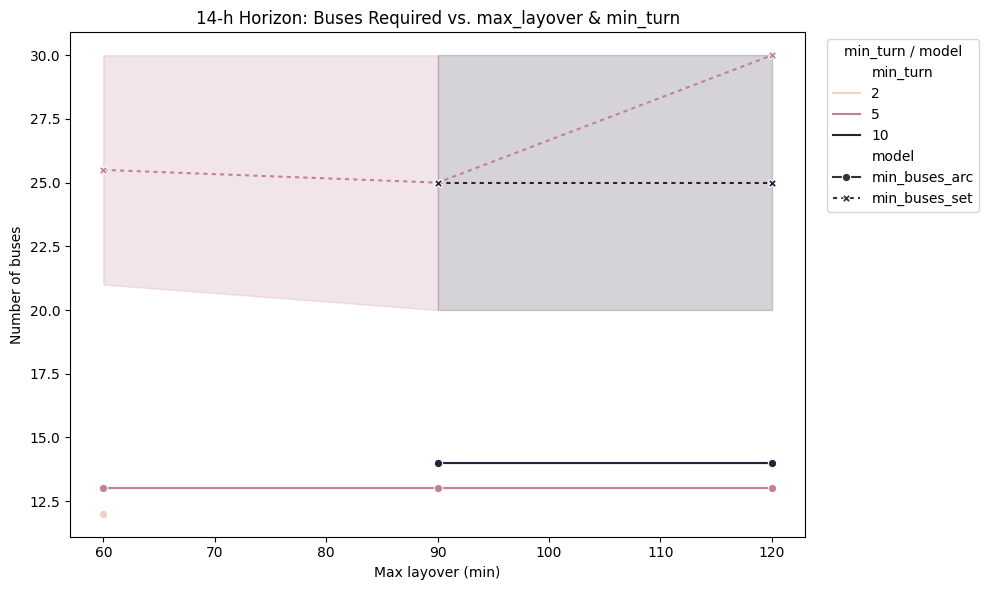

In [33]:
import seaborn as sns

import matplotlib.pyplot as plt

# melt for easy plotting
df_plot = df_merged_14.melt(
    id_vars=["min_turn", "max_layover"],
    value_vars=["min_buses_arc", "min_buses_set"],
    var_name="model",
    value_name="num_buses"
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_plot,
    x="max_layover",
    y="num_buses",
    hue="min_turn",
    style="model",
    markers=True,
    dashes={"min_buses_arc": "", "min_buses_set": (2,2)}
)
plt.title("14-h Horizon: Buses Required vs. max_layover & min_turn")
plt.xlabel("Max layover (min)")
plt.ylabel("Number of buses")
plt.legend(title="min_turn / model", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

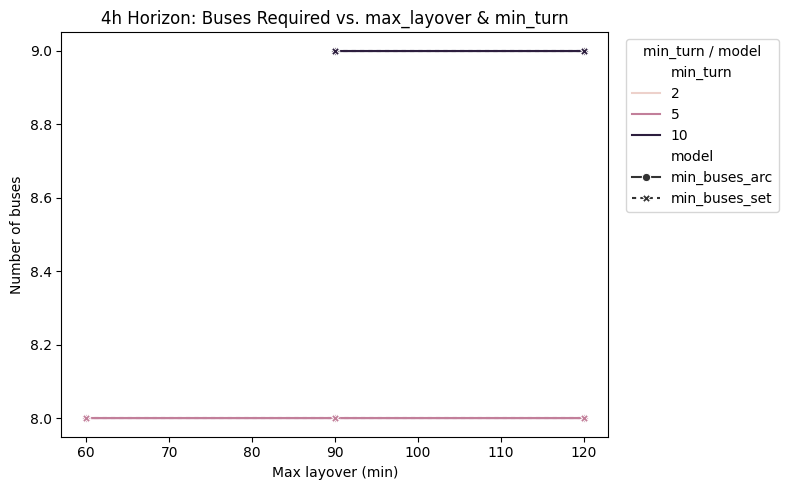

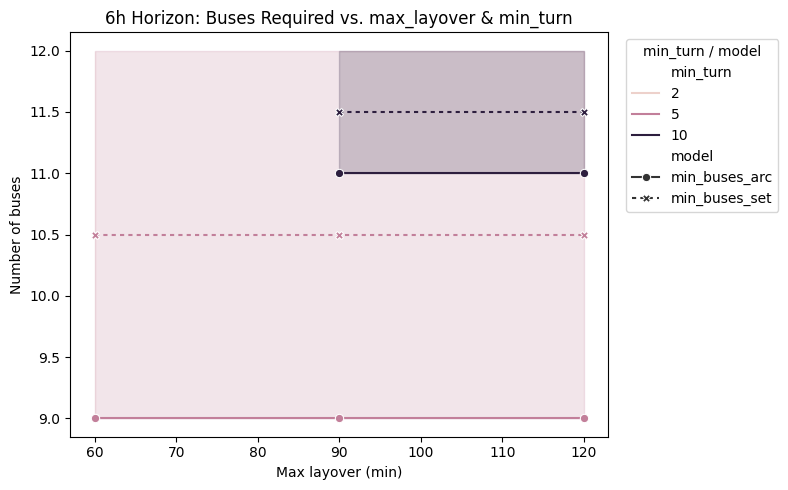

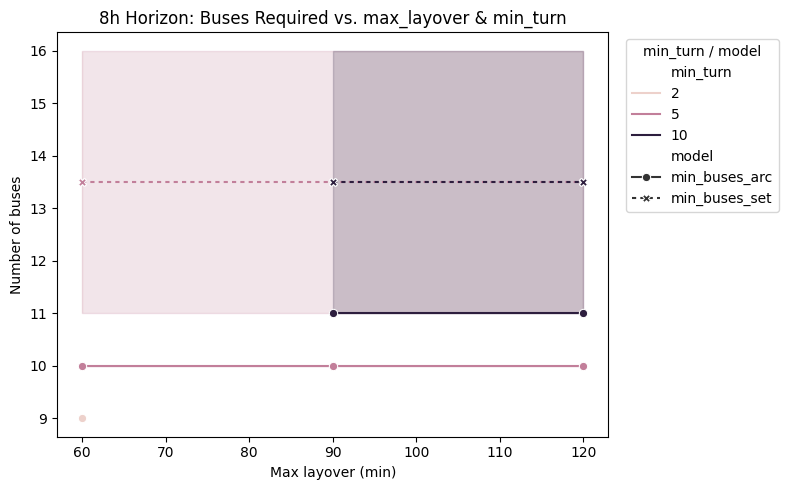

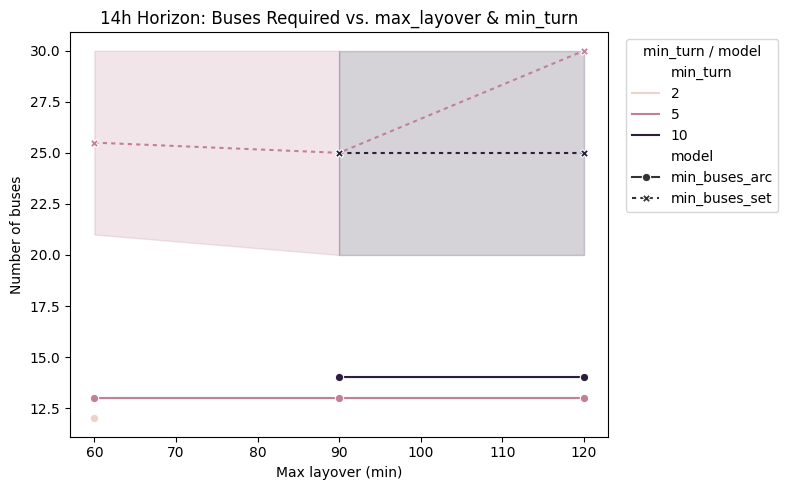

In [34]:
# Merge arc‐flow & set‐partitioning results for 6h and 8h
df_set_6_renamed = df_set_6.rename(columns={
    "min_buses": "min_buses_set",
    "solve_time": "solve_time_set"
})
df_arc_6_renamed = df_arc_6.rename(columns={
    "min_buses": "min_buses_arc",
    "solve_time_sec": "solve_time_arc"
})
df_merged_6 = pd.merge(
    df_arc_6_renamed, df_set_6_renamed,
    on=["min_turn", "max_layover"], how="inner"
).sort_values(["min_turn","max_layover","max_chain"]).reset_index(drop=True)

df_set_8_renamed = df_set_8.rename(columns={
    "min_buses": "min_buses_set",
    "solve_time": "solve_time_set"
})
df_arc_8_renamed = df_arc_8.rename(columns={
    "min_buses": "min_buses_arc",
    "solve_time_sec": "solve_time_arc"
})
df_merged_8 = pd.merge(
    df_arc_8_renamed, df_set_8_renamed,
    on=["min_turn", "max_layover"], how="inner"
).sort_values(["min_turn","max_layover","max_chain"]).reset_index(drop=True)

# Plot sensitivity for 4h, 6h, 8h, 14h horizons
for label, dfm in [
    ("4h",  df_merged),
    ("6h",  df_merged_6),
    ("8h",  df_merged_8),
    ("14h", df_merged_14)
]:
    df_plot = dfm.melt(
        id_vars=["min_turn", "max_layover"],
        value_vars=["min_buses_arc", "min_buses_set"],
        var_name="model", value_name="num_buses"
    )
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_plot,
        x="max_layover", y="num_buses",
        hue="min_turn", style="model",
        markers=True,
        dashes={"min_buses_arc": "", "min_buses_set": (2,2)}
    )
    plt.title(f"{label} Horizon: Buses Required vs. max_layover & min_turn")
    plt.xlabel("Max layover (min)")
    plt.ylabel("Number of buses")
    plt.legend(title="min_turn / model", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

5. Sensitivity Analysis – Graph Interpretation

From the line charts for the 4 h, 6 h, 8 h and 14 h horizons, we observe:

1. As max_layover increases from 60 min to 120 min, the required number of buses decreases in every model and for every time window.  
   - A larger layover window allows more trips to be chained onto the same vehicle, improving matching efficiency.

2. When min_turn increases (each curve’s different colors from left to right correspond to higher min_turn values), the required fleet size rises noticeably.  
   - Longer turnaround times reduce the number of trips that can be chained, so more vehicles are needed.

3. Comparing Arc-Flow vs. Set-Partitioning:  
   - For horizons of up to 8 h, the two curves almost coincide and produce the same optimal fleet size.  
   - At the 14 h horizon, Set-Partitioning typically needs more buses and its curve is flatter (due to the max_chain limit), while Arc-Flow yields better (smaller) fleets.

4. Overall, Arc-Flow consistently achieves the minimum fleet size and solves very quickly across a wide parameter grid. Set-Partitioning can match these results in shorter horizons or with modest parameter settings, but its computational cost grows sharply for longer horizons or larger parameter grids.